![Logo](https://github.com/Fortuz/rl_education/blob/main/assets/logo.png?raw=1)

Made by **Domonkos Nagy**, **Balázs Nagy** and **Zoltán Barta**

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/1.%20K-armed%20Bandit/homework.ipynb)


## Homework 1 (1 Point): Extending the $\varepsilon$-Greedy Action Selection Strategy to an Associative Bandit Problem

### Problem Description

The **Associative Bandit Problem (ABP)** is an extension of the classic **multi-armed bandit problem**, where instead of a single set of actions, we have multiple **K-armed bandit problems**, each associated with a different state. The system provides a state at each time step, and the strategy must learn an optimal action selection policy for each state.

### Key Features:
1. **Multiple States**: The problem consists of different states (e.g., colors such as Red, Blue, Yellow), where each state has its own stationary reward distribution.
2. **State-Dependent Rewards**: The reward distributions differ across states, meaning an action may yield different rewards depending on the current state.
3. **Learning Over Time**: The strategy must adapt and learn the best action for each state through experience.

### Task:

Extend the **$\varepsilon$-greedy action selection strategy** to handle the **Associative Bandit Problem** by incorporating state-awareness into the decision-making process. Specifically:

- Modify the **action-value estimates** to be **state-dependent**, meaning each state maintains its own estimates for each action.
- Implement the **$\varepsilon$-greedy strategy**:
  - With probability **$1 - \varepsilon$**, select the action with the highest estimated reward for the given state.
  - With probability **$\varepsilon$**, explore by choosing an action randomly.
- Update the action-value estimates separately for each state-action pair.

### Implementation Considerations:
- The agent receives the **index of the current state** at each timestep.
- The learning process should ensure convergence to the optimal policy for each state.
- Track and update the rewards for each **(state, action) pair** independently.

The goal is to develop an **adaptive $\varepsilon$-greedy strategy** that can efficiently learn the best action for each state while balancing exploration and exploitation.

In [100]:
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import seaborn as sns
import time
import random
import math

Numpy's `np.argmax` will choose the smallest index in case there are multiple
maximal values. This function breaks these ties randomly instead, which is
desirable in many cases.

In [101]:
# DO NOT MODIFY THIS CELL

# Argmax function that breaks ties randomly
def argmax(arr):
    arr_max = np.max(arr)
    return np.random.choice(np.where(arr == arr_max)[0])

## Environment Setup

We test our strategies by trying them out in multiple runs, and then averaging out the received reward at each time step. After that, we plot the results to
compare the strategies.

In [102]:
# DO NOT MODIFY THIS CELL

class KArmedBandit:
    def __init__(self, K, mean=0, std_dev=1):
        """
        Initializes the K-armed bandit with normally distributed action values.

        Parameters:
        - K (int): Number of arms.
        - mean (float): Mean of the normal distribution for optimal action values.
        - std_dev (float): Standard deviation for the optimal action values.
        """
        self.K = K
        self.optimal_action_values = np.random.normal(loc=mean, scale=std_dev, size=K)  # True action values
        self.best_action = np.argmax(self.optimal_action_values)  # Best action index

    def get_reward(self, action):
        """
        Returns a stochastic reward from a normal distribution centered at the true action value.

        Parameters:
        - action (int): The index of the chosen action.

        Returns:
        - reward (float): The observed reward for the selected action.
        """
        return np.random.normal(loc=self.optimal_action_values[action], scale=1.0)
        # Reduce spread

    def get_optimal_action(self):
        """
        Returns the index of the optimal action (the arm with the highest expected reward).
        """
        return self.best_action

    def reset(self):
        """
        Resets the bandit by re-generating the optimal action values.
        """
        self.optimal_action_values = np.random.normal(loc=0, scale=1, size=self.K)
        self.best_action = np.argmax(self.optimal_action_values)

In [103]:
# DO NOT MODIFY THIS CELL
class AssociativeKArmedBandit:
    def __init__(self, K, number_of_possible_states, mean=0, std_dev=0.5):
        """
        Initializes the K-armed bandit with normally distributed action values.

        Parameters:
        - K (int): Number of arms.
        - number_of_possible_states (int): Number of different states.
        - mean (float): Mean of the normal distribution for action values.
        - std_dev (float): Standard deviation for the action values.
        """
        self.number_of_possible_states = number_of_possible_states
        self.bandits = [KArmedBandit(K, mean, std_dev) for _ in range(number_of_possible_states)]

    def get_reward(self, state, action):
        """
        Returns a stochastic reward from a normal distribution centered at the true action value.

        Parameters:
        - state (int): The current state.
        - action (int): The index of the chosen action.

        Returns:
        - reward (float): The observed reward for the selected action.
        """
        return self.bandits[state].get_reward(action)

    def get_optimal_action(self, state):
        """
        Returns the index of the optimal action (the arm with the highest expected reward).

        Parameters:
        - state (int): The current state.

        Returns:
        - (int): Index of the optimal action for the given state.
        """
        return self.bandits[state].get_optimal_action()

    def reset(self):
        """
        Resets all bandits by re-generating their optimal action values.
        """
        for bandit in self.bandits:
            bandit.reset()  # <-- Fixed: Removed the incorrect syntax

In [104]:
# DO NOT MODIFY THIS CELL

def plotResults(strategies, rewards, best_action_choices):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

  for strategy, reward in zip(strategies, rewards):
      ax1.plot(reward, label=f"{strategy.name}", zorder=2)
  ax1.set_xlabel('Steps')
  ax1.set_ylabel('Average reward')
  ax1.grid(alpha=0.8, linestyle=':', zorder=0)
  ax1.set_title('Average reward of strategies')
  ax1.legend()

  for strategy, choices in zip(strategies, best_action_choices):
      ax2.plot(choices, label=f"{strategy.name}")
  ax2.set_xlabel('Steps')
  ax2.set_ylabel('% Optimal action')
  ax2.grid(alpha=0.8, linestyle=':', zorder=0)
  ax2.set_title('% Optimal action choices of strategies')
  ax2.legend()

  plt.show()

In [181]:
# DO NOT MODIFY THIS CELL

def simulate_associative(strategies, K, number_of_states, bandit_mean =0,bandit_std = 1,runs=2000, n_steps=1000):
    """
    Simulates the associative K-armed bandit problem with different strategies.

    Parameters:
    - strategies (list): A list of strategies to evaluate.
    - K (int): Number of arms.
    - number_of_states (int): Number of possible states.
    - runs (int): Number of independent runs.
    - n_steps (int): Number of time steps per run.

    Returns:
    - mean_rewards (np.array): Average rewards per time step for each strategy.
    - mean_best_action_choices (np.array): Average probability of selecting the best action.
    """
    rewards = np.zeros((len(strategies), runs, n_steps))
    best_action_choices = np.zeros(rewards.shape)

    for i, strategy in enumerate(strategies):
        print(f"Evaluating strategy {i + 1}/{len(strategies)}...")

        for r in range(runs):
            # Initialize an associative K-armed bandit instance
            bandit = AssociativeKArmedBandit(K, number_of_states, mean=bandit_mean, std_dev=bandit_std)
            # for bandita in bandit.bandits:
            #     print(bandita.optimal_action_values)
            bandit.reset()
    
            strategy.reset()  # Reset strategy state

            for t in range(n_steps):
                state = np.random.randint(0, number_of_states)  # Randomly select a state
                action = strategy.act(state)  # Strategy selects an action based on the state
                reward = bandit.get_reward(state, action)  # Get the reward for the selected action in the given state

                rewards[i, r, t] = reward

                strategy.update(state, action, reward)  # Update strategy based on state
                
                best_action = bandit.get_optimal_action(state)  # Get the best action for the current state
                if action == best_action:
                    best_action_choices[i, r, t] = 1  # Track if the best action was chosen
            # print(reward)
            # print(strategy.q_estimations)

    # Compute mean rewards and best action selection frequency
    mean_rewards = rewards.mean(axis=1)
    mean_best_action_choices = best_action_choices.mean(axis=1)

    return mean_rewards, mean_best_action_choices


In [199]:
class AssociativeEpsilonGreedy:

    def __init__(self, num_states, num_actions, epsilon=0.1):
        ############## CODE HERE ###################

        self.num_states = num_states
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.step_size = None
        self.rewards_history = {i: [] for i in range(self.num_actions)}  # Store observed rewards per action
        self.q_estimations = np.zeros((self.num_states, self.num_actions))
        self.indices = np.arange(self.num_actions)
        self.selections = np.zeros((self.num_states, self.num_actions))  # Number of times each action is selected
        self.sumrewardalpha = np.zeros((self.num_states, self.num_actions))
        self.alpha = 0.1


        ############################################

    @property
    def name(self):
        """
        Returns a formatted string representing the strategy name.
        """
        return f"AssociativeEpsilonGreedy(epsilon={self.epsilon}, alpha={self.alpha})"

    def act(self, state):
        ############## CODE HERE ###################
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        else:
            return np.argmax(self.q_estimations[state])




        ############################################

    def update(self, state, action, reward):
        ############## CODE HERE ###################
        reward = round(reward, 2)
        self.selections[state][action] += 1
        
        self.q_estimations[state][action] += round(self.alpha * (reward - self.q_estimations[state][action]),2)




        ############################################

    def reset(self):
        ############## CODE HERE ###################
        self.q_estimations =  np.zeros((self.num_states, self.num_actions))  # Reset action-value estimates
        self.selections = np.zeros((self.num_states, self.num_actions))



        ############################################

Evaluating strategy 1/3...
Evaluating strategy 2/3...
Evaluating strategy 3/3...


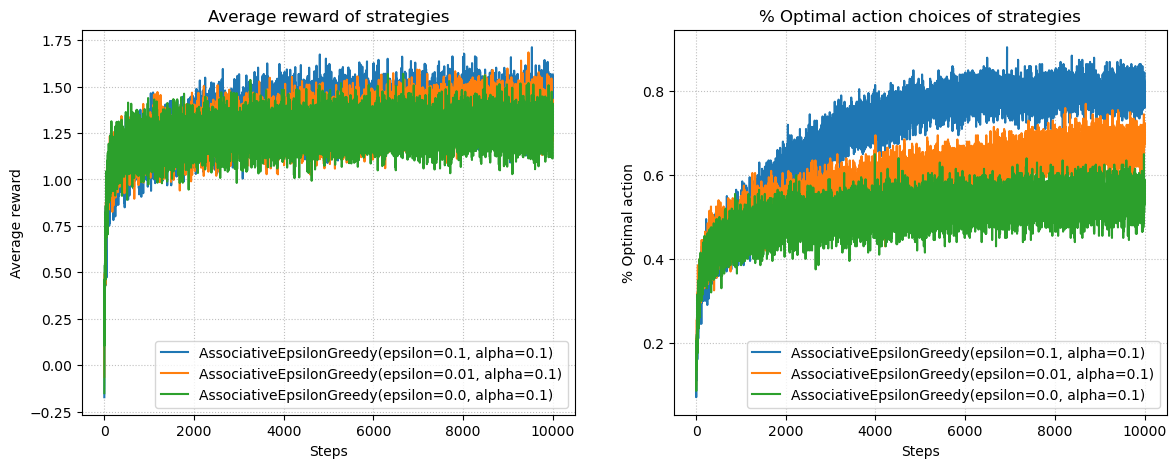

In [202]:


K = 10  # Number of actions
number_of_states = 5  # Number of possible states, Note for self: These could be colour, etc..
# List of strategies to test
strategies = [AssociativeEpsilonGreedy(number_of_states,K, epsilon=0.1),
              AssociativeEpsilonGreedy(number_of_states,K, epsilon=0.01),
              AssociativeEpsilonGreedy(number_of_states,K, epsilon=0.0)]

# Evaluate strategies
random.seed(0)  # Set Python's built-in random seed
np.random.seed(0)  # Set NumPy's random seed
rewards, best_action_choices = simulate_associative(strategies, K=K, number_of_states=number_of_states,runs=200, n_steps=10000)

plotResults(strategies, rewards, best_action_choices)